# HW06: ML and Causal Inference (due November 9th)

**As a first part of THIS WEEK'S homework (HW06) you will have to provide feedback to two of your classmates' essays on Eduflow.** On Eduflow, you will be automatically assigned to the two essays you have to provide feedback to on Friday, in case you want to start ahead.

### For the coding part of the homework, you will have to solve only one of the three exercises.

## Exercise 1: Double Machine learning with XGboost

In this exercise you will investigate a research question similar to the one in HW02. Namely, what is the effect of being in a Union on wages? You will use the same data as in HW02 (description of the variables can be found [here](https://rdrr.io/rforge/sampleSelection/man/nlswork.html)). Although, here instead of just including controls, you will estimate the effect of union membership on wages using double machine learning and you will use XGboost as machine learning algorithm. The regression of reference is the following: 

<center> $ln\_wage_i = \beta_0 + \beta_1 union_i +\varepsilon_i$ </center>

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
# Load Data (NLSY)
import pandas as pd
df = pd.read_stata('http://www.stata-press.com/data/r16/nlswork.dta')
df = df.dropna()

In [2]:
df.head()

,idcode,year,birth_yr,age,race,msp,nev_mar,grade,collgrad,not_smsa,...,south,ind_code,occ_code,union,wks_ue,ttl_exp,tenure,hours,wks_work,ln_wage
2,1,72,51,20.0,black,1.0,0.0,12.0,0,0.0,...,0.0,4.0,6.0,1.0,0.0,2.256410,0.916667,40.0,51.0,1.589977
5,1,77,51,25.0,black,0.0,0.0,12.0,0,0.0,...,0.0,12.0,8.0,0.0,0.0,3.775641,1.500000,32.0,52.0,1.778681
7,1,80,51,28.0,black,0.0,0.0,12.0,0,0.0,...,0.0,5.0,6.0,1.0,0.0,5.294872,1.833333,45.0,75.0,2.551715
9,1,85,51,33.0,black,0.0,0.0,12.0,0,0.0,...,0.0,5.0,6.0,1.0,0.0,7.160256,1.916667,42.0,97.0,2.614172
10,1,87,51,35.0,black,0.0,0.0,12.0,0,0.0,...,0.0,5.0,6.0,1.0,0.0,8.987180,3.916667,45.0,95.0,2.536374


In [3]:
import numpy as np
Y = df['ln_wage']
D = df['union']

In [4]:
import statsmodels.formula.api as smf

## Run the regression written above
ols1 = smf.ols('ln_wage ~ union', df).fit(cov_type = 'hc1')
# ‘HC0’, ‘HC1’, ‘HC2’, ‘HC3’: heteroscedasticity robust covariance
coeff = ols1.params
se = ols1.bse

print('The average coefficient is: ' + str(coeff.union))
print('The standard error is: ' + str(se.union))

The average coefficient is: 0.250203972784397
The standard error is: 0.008866849007917196


**What could be potential sources of bias (i.e. confounders)?**

In [5]:
# fill in X with all predictors that are not colliders
cont_vars = ['year', 'age']
cat_vars = ['race', 'collgrad', 'msp', 'not_smsa', 'c_city', 'south' ]


from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df[cat_vars] = encoder.fit_transform(df[cat_vars])
df[cont_vars] = df[cont_vars].astype('float32')

X = df[cat_vars + cont_vars]


In [6]:
# split into sample A and sample B
from sklearn.model_selection import train_test_split
X_a, X_b, D_a, D_b, Y_a, Y_b= train_test_split(X, D, Y, test_size=0.5)
X_atrain, X_atest, D_atrain, D_atest, Y_atrain, Y_atest, = train_test_split(X_a, D_a, Y_a, test_size=0.2)
X_btrain, X_btest, D_btrain, D_btest, Y_btrain, Y_btest = train_test_split(X_b, D_b, Y_b, test_size=0.2)

# Within each sample, make a validation set for xgboost early stopping
#TODO

In [7]:
# Step 1. In both samples, train an xgboost regressor model to predict log wages (outcome Y)
# use early stopping.
from xgboost import XGBRegressor

xgbregress_a = XGBRegressor()
xgbregress_b = XGBRegressor()

xgbregress_a.fit(X_atrain, Y_atrain)
Y_hat_a = xgbregress_a.predict(X_atest)

xgbregress_b.fit(X_btrain, Y_btrain)
Y_hat_b = xgbregress_b.predict(X_btest)

In [8]:
# Step 2. In both samples, train an xgboost classifier model to predict union status (treatment D)
# use early stopping.
from xgboost import XGBClassifier
xgbclass_a = XGBClassifier()
xgbclass_b = XGBClassifier()

xgbclass_a.fit(X_atrain, D_atrain)
D_hat_a = xgbclass_a.predict(X_atest)

xgbclass_b.fit(X_btrain, D_btrain)
D_hat_b = xgbclass_b.predict(X_btest)

In [9]:
# Step 3. Cross-fitting: Form predictions in other sample.

# predict wages in sample A using model trained in sample B:
Y_hat_a_cross = xgbregress_b.predict(X_a)

# vice versa:
Y_hat_b_cross = xgbregress_a.predict(X_b)
    
# predict union status in sample A using model trained in sample B:
D_hat_a_cross = xgbclass_b.predict(X_a)

# vice versa:
D_hat_b_cross = xgbclass_a.predict(X_b)
    

Recall that residuals for a variable $Z_i$ are computed as follows:

<center>$\tilde{Z}_i = Z_i - \hat{Z}_i$</center>

where $\hat{Z}_i$ is the predicted value of $Z_i$

In [10]:
# Compute residuals for wages and union status.

# residualized wages in samples A and B:
y_tilde_a =  Y_a - Y_hat_a_cross
y_tilde_b =  Y_b - Y_hat_b_cross

# residualized union status in samples A and B:
D_tilde_a =  D_a - D_hat_a_cross
D_tilde_b =  D_b - D_hat_b_cross

In [11]:
# Step 4. Run OLS regressions of the residualized variables and produce Double ML estimate
## use robust standard errors 

df_a = pd.DataFrame()
df_a ['ln_wage'] = y_tilde_a
df_a ['union'] = D_tilde_a

df_b = pd.DataFrame()
df_b ['ln_wage'] = y_tilde_b
df_b ['union'] = D_tilde_b

from statsmodels.iolib.summary2 import summary_col

dml = smf.ols('ln_wage ~ union', df_a).fit(cov_type='hc1')
print(summary_col([ols1, dml], float_format='%0.3f',  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}, regressor_order=['union']))


               ln_wage I ln_wage II
-----------------------------------
union          0.250     0.153     
               (0.009)   (0.011)   
Intercept      1.656     -0.030    
               (0.004)   (0.005)   
R-squared      0.052     0.029     
R-squared Adj. 0.052     0.029     
N              13452     6726      
Standard errors in parentheses.


**Compare the estimates form this and the previous regression. How do these change?**

The coefficient from the double machine learning is smaller in magnitude, but still statistically significant.

**Interpret the coefficient from the double ml approach. Can it be interpreted as causal?**

Being in a union increases wages by 25%. However, this is still not a causal estimate as there could be some unobserved confounders biasing the result.

## Exercise 2: Synthetic Control Method

In this exercise we will investigate the economic effects of conflict by focusing on the Basque Country. In particular, we will focus on terrorist conflicts in late 1960's in this area and use as comparison group all other regions of Spain that did not experience terrorism. The (raw) reference regression is the following:

<center>$gdpcap_r = \beta_0 + \beta_1 terrorism_r + \varepsilon_r$</center>

where $gdpcap_r$ is GDP per capita in region $r$ and $terrorism_r$ is a dummy equal to 1 if terrorist conflict happened in that region.

In [12]:
import pandas as pd
import statsmodels.formula.api as smf

df = pd.read_csv('data/HW06_data_scm.csv')
del df['Unnamed: 0']
del df['regionno']
df = df.loc[df["regionname"] != "Spain (Espana)"] 

df['terrorism'] = df['regionname']=='Basque Country (Pais Vasco)'
df['terrorism'] = df['terrorism'].astype('int')
df.head()

,regionname,year,gdpcap,sec.agriculture,sec.energy,sec.industry,sec.construction,sec.services.venta,sec.services.nonventa,school.illit,school.prim,school.med,school.high,school.post.high,popdens,invest,terrorism
43,Andalucia,1955,1.688732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
44,Andalucia,1956,1.758498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
45,Andalucia,1957,1.827621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
46,Andalucia,1958,1.852756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
47,Andalucia,1959,1.878035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


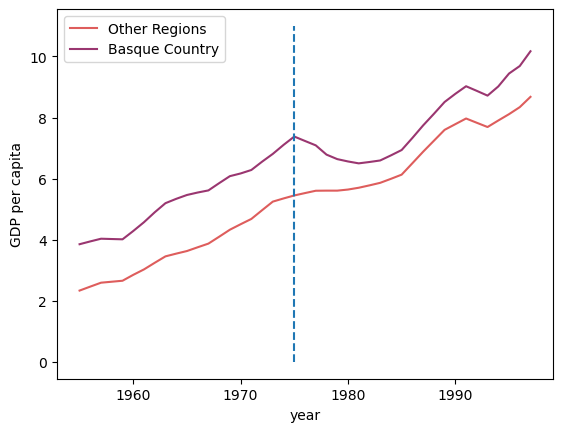

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

##plot gdp per capita over time separately for basque country and other regions of spain
## (i.e., separately for terrorism == 1 or 0)

palette = sns.color_palette("flare", 2)
plot = sns.lineplot(data=df, x='year', y='gdpcap', hue='terrorism', palette=palette, errorbar=None)

plot.vlines(x=1975, ymin=0, ymax=11, linestyle="dashed")
plt.ylabel("GDP per capita")
plot.legend_.set_title('')
new_labels = ['Other Regions', 'Basque Country']
for t, l in zip(plot.legend_.texts, new_labels):
    t.set_text(l)

**Does the parallel trend assumption hold? If not, why do you think this is the case?**

The parallel trend assumption seems to hold except for the last period. This suggests that the Basque Country was entering a period of economic growth, contrary to the rest of Spain, meaning that any first difference or diff-in-diff estimate is likely to overestimate the effect of terrorism.

In [14]:
## run a regression of terrorism on gdp per capita
df['post'] = (df['year']>1975).astype('int')
df['terr_post'] = df['post']*df['terrorism']

ols = smf.ols('gdpcap ~ terrorism', data=df).fit()
did = smf.ols('gdpcap ~ terrorism + post + terr_post', data=df).fit()
print(summary_col([ols, did], float_format='%0.3f',  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}, regressor_order=['terrorism', 'terr_post', 'post']))


               gdpcap I gdpcap II
---------------------------------
terrorism      1.335    1.635    
               (0.353)  (0.372)  
terr_post               -0.586   
                        (0.519)  
post                    3.070    
                        (0.126)  
Intercept      5.318    3.747    
               (0.086)  (0.090)  
R-squared      0.019    0.470    
R-squared Adj. 0.018    0.468    
N              731      731      
Standard errors in parentheses.


**What could be potential threats to a causal interpretation of this result?**

The basque country and other regions of Spain may start from a different level of gdp per capita which is not accounted by the previous regression.

In [ ]:
from SyntheticControlMethods import Synth, DiffSynth
del df['terrorism']
del df['post']
del df['terr_post']

##fit the synthetic control 
sc = Synth(df, "gdpcap", "regionname", "year", 1976, "Basque Country (Pais Vasco)", n_optim=5, pen=0)


In [ ]:
##visualize the plot 
sc.plot(["original"], treated_label="Basque Country", 
            synth_label="Synthetic Basque Country", treatment_label="Terrorism")

**What can you conclude about the effect of conflict on GDP?**

All the results present a robust negative effect of conflict on GDP.

In [ ]:
## Show which spanish regions were used to create the synthetic control

print(sc.original_data.weight_df)

## Exercise 3: Heterogenous Treatment Effects

In this exercise we will investigate the effect of case management on mental health outcomes. These data come from a randomized control trial where patients were assigned to *intensive* or *standard* case management. In this context, the treatment is being assigned to the **intensive** case management while patients assigned to the **standard** case management belong to the control group..

In this exercise we will focus on heterogenous treatment effects, rather than on isolating the casual effect of the treatment. In particular, we will investigate characteristics of individuals who are most and least responsive to the treatment, i.e., to being assigned to the intensive case management. 

In [1]:
import pandas as pd
import statsmodels.formula.api as smf

df = pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta')
df = df.dropna()
pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta', iterator=True).variable_labels()

{'trialid': 'Trial ID',
 'centreid': 'Trial centre',
 'status': 'Patient status at baseline',
 'age': 'Age in years at baseline',
 'sex': 'Sex',
 'afcarib': 'Ethnic group',
 'ocfabth': "Father's social class at birth",
 'chron1l': 'Months since onset of psychosis, logged',
 'hos94': 'Days in hospital for psychiatric reasons: 2 years before baseline',
 'cprs94': 'Psychopathology at baseline (CPRS)',
 'das94': 'Disability at baseline (DAS)',
 'sat94': '(Dis)satisfaction with services at baseline',
 'rand': 'Randomised group',
 'hos96': 'Days in hospital for psychiatric reasons: 2 years after baseline',
 'cprs96': 'Psychopathology at 2 years (CPRS)',
 'sat96': '(Dis)satisfaction with services at 2 years'}

In [2]:
df.head()

,trialid,centreid,status,age,sex,afcarib,ocfabth,chron1l,hos94,cprs94,das94,sat94,rand,hos96,cprs96,sat96
1,107.0,St George's,Out-patient,27.0,male,Other,A,3.178054,80.0,4.0,0.285714,18.0,Intensive case management,27.0,3.0,22.000
2,222005.0,St Mary's,In hospital,41.0,male,Other,D,4.521789,240.0,6.0,0.750000,15.0,Intensive case management,15.0,13.0,9.000
3,222018.0,St Mary's,In hospital,25.0,male,Other,C2,4.094345,48.0,12.0,0.125000,18.0,Intensive case management,263.0,6.0,21.375
5,312015.0,King's,Out-patient,31.0,female,Other,A,4.787492,60.0,28.0,2.375000,20.0,Intensive case management,45.0,19.0,17.000
6,221023.0,St Mary's,In hospital,35.0,male,Afro-Caribbean,C2,4.430817,60.0,25.0,1.571428,24.0,Intensive case management,58.0,27.0,19.125


The treatment variable is $rand$, the post-treatment outcomes are $hos96$, $cprs96$ and $sat96$.

In [3]:
treatvar = 'rand'
df[treatvar].value_counts()

Intensive case management    130
Standard case management     116
Name: rand, dtype: int64

In [4]:
outcomes = ['sat96', 'hos96', 'cprs96']
df[outcomes].describe()

,sat96,hos96,cprs96
count,246.000000,246.000000,246.000000
mean,17.271341,65.500000,17.790587
std,4.723009,104.046722,14.090911
min,9.000000,0.000000,0.000000
25%,14.000000,0.000000,7.000000
50%,17.000000,15.000000,15.000000
75%,20.187500,93.500000,26.000000
max,32.000000,692.000000,71.000000


In addition to these variables we need a set of covariates that we want to use to identify individuals who are most and least responsive to treatment. We also encode categorical covariates and prepare them for the ML model

In [5]:
#Encoding Categorical covariates and preparing the data for tensorflow
covariates = ['status', 'sex', 'sat94', 'ocfabth', 'hos94', 'das94', 'cprs94', 'age', 'afcarib']
covariates_cat = ['status', 'sex', 'ocfabth', 'afcarib']

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df[covariates_cat] = encoder.fit_transform(df[covariates_cat])
df[covariates] = df[covariates].astype('float32')
df[covariates].head()

,status,sex,sat94,ocfabth,hos94,das94,cprs94,age,afcarib
1,1.0,1.0,18.0,0.0,80.0,0.285714,4.0,27.0,1.0
2,0.0,1.0,15.0,4.0,240.0,0.750000,6.0,41.0,1.0
3,0.0,1.0,18.0,3.0,48.0,0.125000,12.0,25.0,1.0
5,1.0,0.0,20.0,0.0,60.0,2.375000,28.0,31.0,1.0
6,0.0,1.0,24.0,3.0,60.0,1.571428,25.0,35.0,0.0


In [7]:
# Subset the dataset by treatment and control
# Within each sample, create a training, a test and a validation set
from sklearn.model_selection import train_test_split


df_treat = df.loc[df[treatvar]=='Intensive case management']
df_control = df.loc[df[treatvar]!='Intensive case management']

Xt_train, Xt_test, yt_train, yt_test = train_test_split(df_treat[covariates], df_treat['hos96'], test_size=0.3)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(df_control[covariates], df_control['hos96'], test_size=0.3)

In [16]:
##choose one of the three outcomes to analyze
## using xgboost regressor train two model to predict the outcome from the covariates
## the first model should be trained on the treated sample, while the second on the control
## use early stopping

from xgboost import XGBRegressor
xgbr_treat = XGBRegressor()
xgbr_control = XGBRegressor()

xgbr_treat.fit(Xt_train, yt_train)
xgbr_control.fit(Xc_train, yc_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [17]:
##get predicted outcomes using the combined test sets for both models 

test_set = Xt_test.append(Xc_test) 
yhat_treat = xgbr_treat.predict(test_set)
yhat_control = xgbr_control.predict(test_set)

In [18]:
##find the three individuals in the test set that are most and least responsive to the treatment
##namely the three individuals for who the treatment effect is larger and those for who it is smaller

test_set['treat_effect'] = yhat_treat - yhat_control
test_set = test_set.sort_values('treat_effect', axis=0)
most_least_treat = test_set[:3].append(test_set[-3:])
most_least_treat

,status,sex,sat94,ocfabth,hos94,das94,cprs94,age,afcarib,treat_effect
86,0.0,1.0,24.0,2.0,199.0,3.000000,24.000000,23.0,1.0,-264.464478
212,1.0,0.0,12.0,4.0,59.0,1.200000,13.000000,62.0,1.0,-243.161270
119,1.0,0.0,18.0,4.0,120.0,1.333333,32.000000,61.0,0.0,-230.616043
475,0.0,1.0,19.0,3.0,120.0,0.000000,4.000000,30.0,0.0,171.199783
12,1.0,0.0,16.0,2.0,30.0,1.400000,26.000000,37.0,1.0,181.799286
338,0.0,0.0,16.0,4.0,19.0,2.333332,21.776737,64.0,0.0,201.599548


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

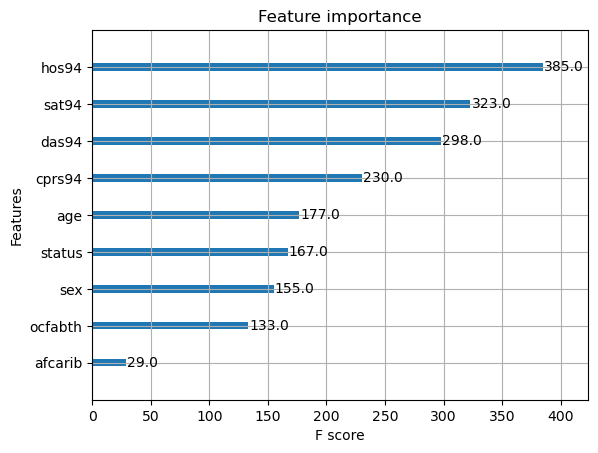

In [19]:
##visualize and comment on the covariates of these individuals 
from xgboost import plot_importance

xgb = XGBRegressor()
xgb.fit(test_set[covariates], test_set['treat_effect'])

plot_importance(xgb)